# Tag with SARSA

Lets take a look how a SARSA agent performs on the tag problem. We will train it against some random agents, and against another SARSA agent to see how things go.

We will just look how episodes duration evolve over a single training round, and we will use a moving average to make things visible.

With q-learning we used a decaying epsilon to make sure the police was optimal. Since SARSA is an on-policy algorithm I will let epsilon be fixed, to see if the agent learns how to deal with the exploration moves.

In [1]:
import sys

sys.path.append("../..")

from grid_world.grid_world import GridWorld
from grid_world.visualization.format_objects import get_world_str
from utils.returns import returns_from_reward
from notebooks.utils.basics import basic_actions, basic_tag_reward
from exploring_agents import SarsaAgent, RandomAgent
from notebooks.utils.experimentation import moving_average
from exploring_agents.training import train_tag_agents
from notebooks.utils.worlds import tagging_world_01
from grid_world.action import GWorldAction

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(50)

In [2]:
gworld = tagging_world_01
print(get_world_str(gworld))

5                ⚐ 

4                  

3       █  █       

2       █          

1 █  █  █          

0 ⚐                

  0  1  2  3  4  5 


## Sarsa vs Random

Ok, now lets see how a SARSA agent performs against a random one. Both trying to catch, and to run.

In [3]:
random_agent = RandomAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
)


agent_1 = SarsaAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.3,
    epsilon=0.01,
)

episode_lengths, agent_1_returns, agent_2_returns = train_tag_agents(
    agent_1=agent_1,
    agent_2=random_agent,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
)

In [4]:
print(f"Agent 1 wins {np.sum([x > 0 for x in agent_1_returns])/len(agent_1_returns):.3f} of episodes, with {np.mean(episode_lengths):.2f} average steps")

Agent 1 wins 0.912 of episodes, with 68.48 average steps


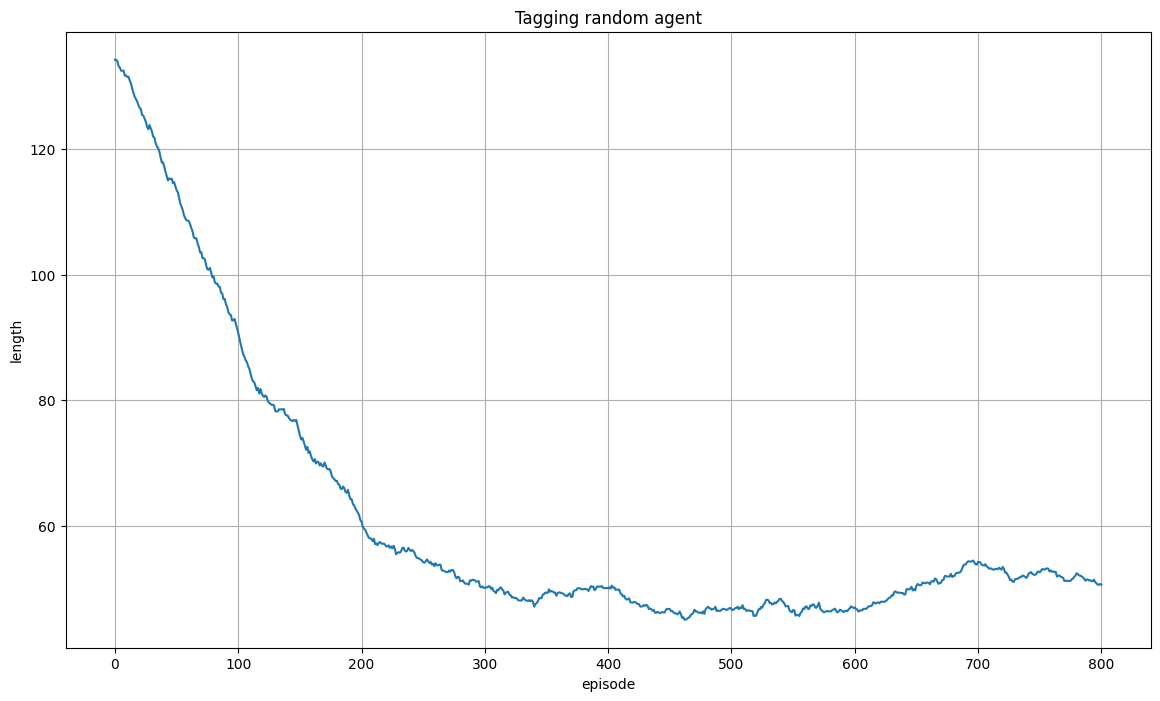

In [5]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    moving_average(np.array(episode_lengths), 200),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Tagging random agent")


plt.show()

In [6]:
agent_2 = SarsaAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.3,
    epsilon=0.01,
)

episode_lengths, agent_1_returns, agent_2_returns = train_tag_agents(
    agent_1=random_agent,
    agent_2=agent_2,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
)

In [7]:
print(f"Agent 2 wins {np.sum([x > 0 for x in agent_2_returns])/len(agent_2_returns):.3f} of episodes, with {np.mean(episode_lengths):.2f} average steps")

Agent 2 wins 0.844 of episodes, with 189.00 average steps


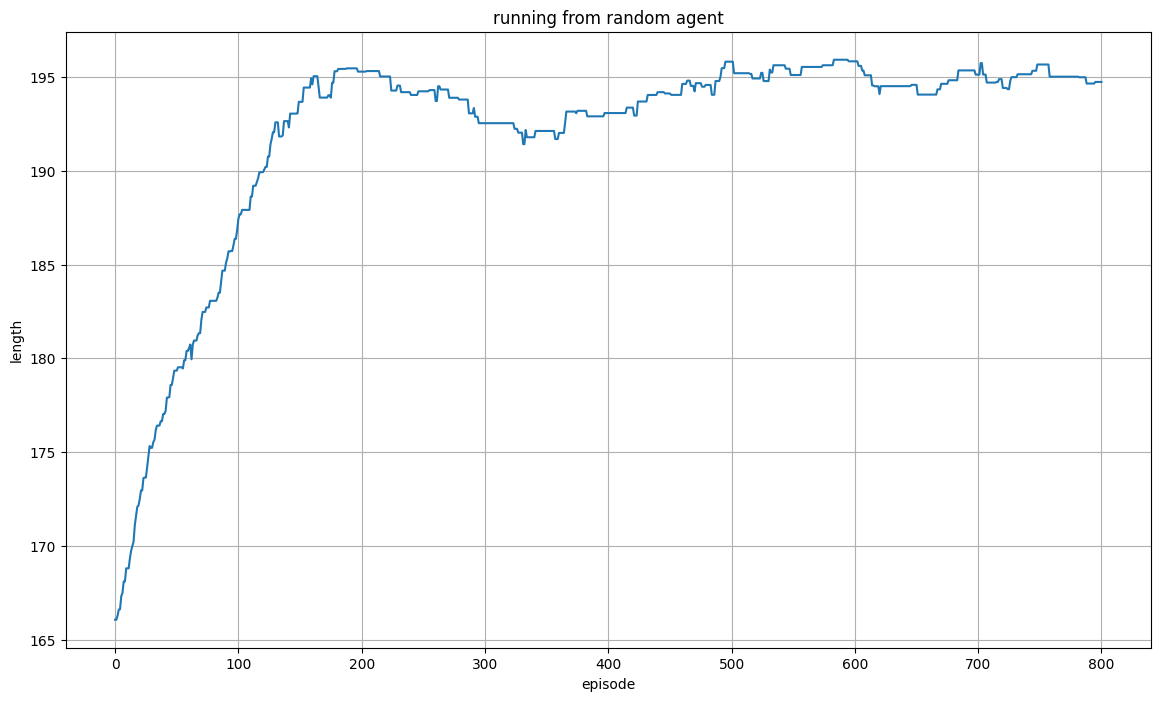

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    moving_average(np.array(episode_lengths), 200),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("running from random agent")


plt.show()

After some training our SARSA agent is able to catch a random one pretty fast. 

The second case is more interesting. There is a "winning" strategy for agent 2, and we could achieve it by decaying $\epsilon$(as we did with q-learning). However, since SARSA is an on-policy agent it is interesting to see its performance with a fixed $\epsilon$. And we can see that although the policy can not be optimal(because of the exploration), the agent learns how to deal with this, and 

## Adversarial Agents

Finally lets see what happens with two SARSA agents going against each other.

In [9]:
agent_1 = SarsaAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.3,
    epsilon=0.01,
)

agent_2 = SarsaAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.3,
    epsilon=0.01,
)

episode_lengths, agent_1_returns, agent_2_returns = train_tag_agents(
    agent_1=agent_1,
    agent_2=agent_2,
    world=gworld,
    episodes=int(1e4),
    episode_max_length=200,
)

In [10]:
print(f"Agent 2 wins {np.sum([x > 0 for x in agent_2_returns])/len(agent_2_returns):.3f} of episodes, with {np.mean(episode_lengths):.2f} average steps")

Agent 2 wins 0.879 of episodes, with 187.43 average steps


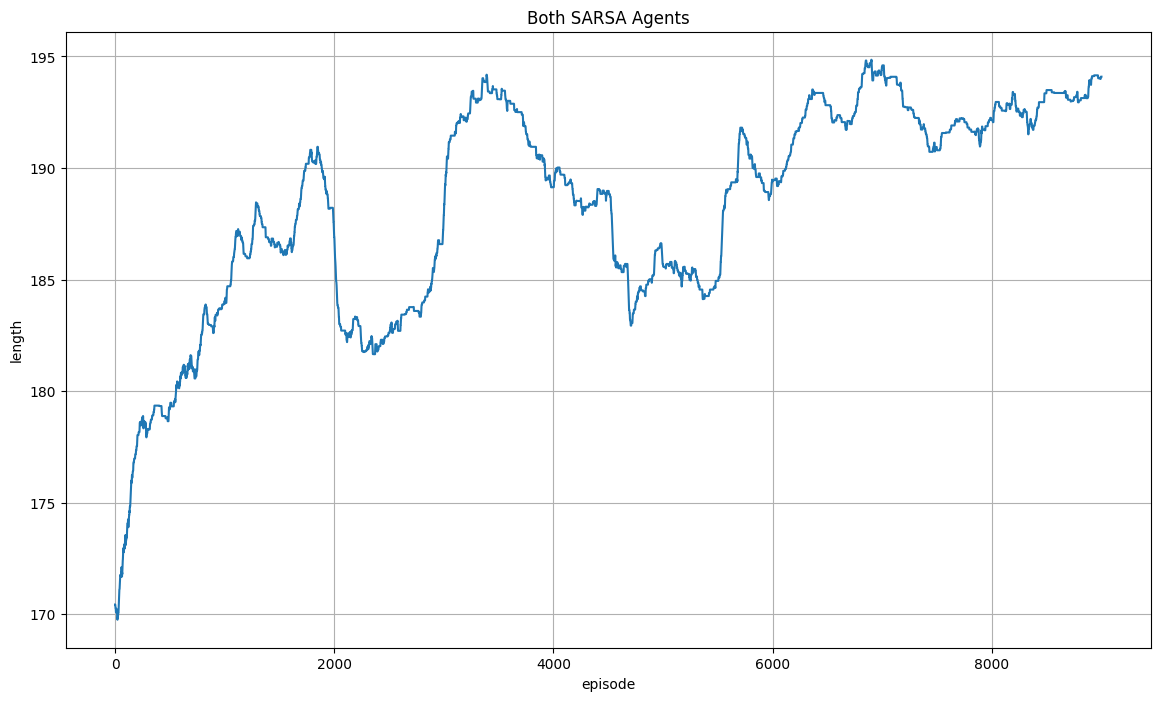

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    moving_average(np.array(episode_lengths), 1000),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Both SARSA Agents")


plt.show()

In [12]:
base_path = "../.."
prefix = f"{base_path}/persistence/agents/"
filename1 = "sarsa_agent_1_tagging_world_01"
filename2 = "sarsa_agent_2_tagging_world_01"

agent_1.dump(f"{prefix}{filename1}")
agent_2.dump(f"{prefix}{filename2}")

This last cell dumps the agents so we can reuse then. You can check what is going by running(you will need to execute the notebook first though, as the agents are not being commited to github):

`python grid_world/visualization/animation_scripts/tag/sarsa_vs_sarsa_01.py`

It looks like agent 2 is improving, but it is pretty hard to tell from this plot what is going on, so lets see what hapens if we remove Agent 2 exploration rate.

In [13]:
agent_2.policy.epsilon = 0

episode_lengths_2, agent_1_returns_2, agent_2_returns_2 = train_tag_agents(
    agent_1=agent_1,
    agent_2=agent_2,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
    randomize_starting_positions=False
)

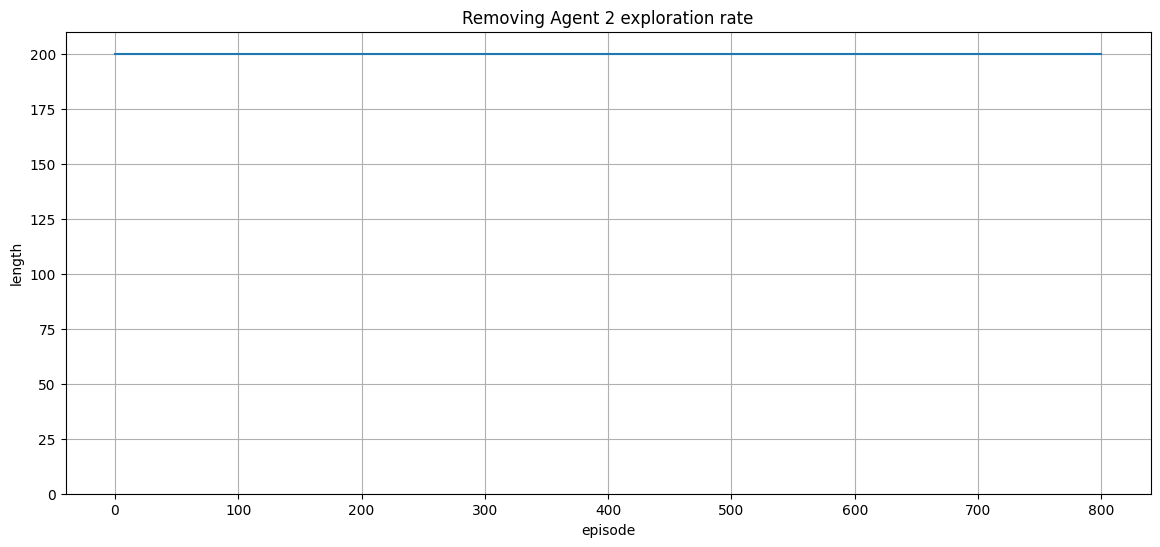

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(episode_lengths_2), 200)
)

ax.set(xlabel="episode", ylabel="length", ylim = (0, 210))
ax.grid()
ax.set_title("Removing Agent 2 exploration rate")


plt.show()

Ok, this makes sense! Agent 2 learned how to win, but because of the exploration rate he makes some suboptimal choices, which agent was exploring to get some ocasional wins; when we remove the exploration rate agent 1 has no chance.

On the other hand lets how Agent 1 would fare against the random agent.

In [15]:
episode_lengths_2, agent_1_returns_2, agent_2_returns_2 = train_tag_agents(
    agent_1=agent_1,
    agent_2=random_agent,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
    randomize_starting_positions=False
)

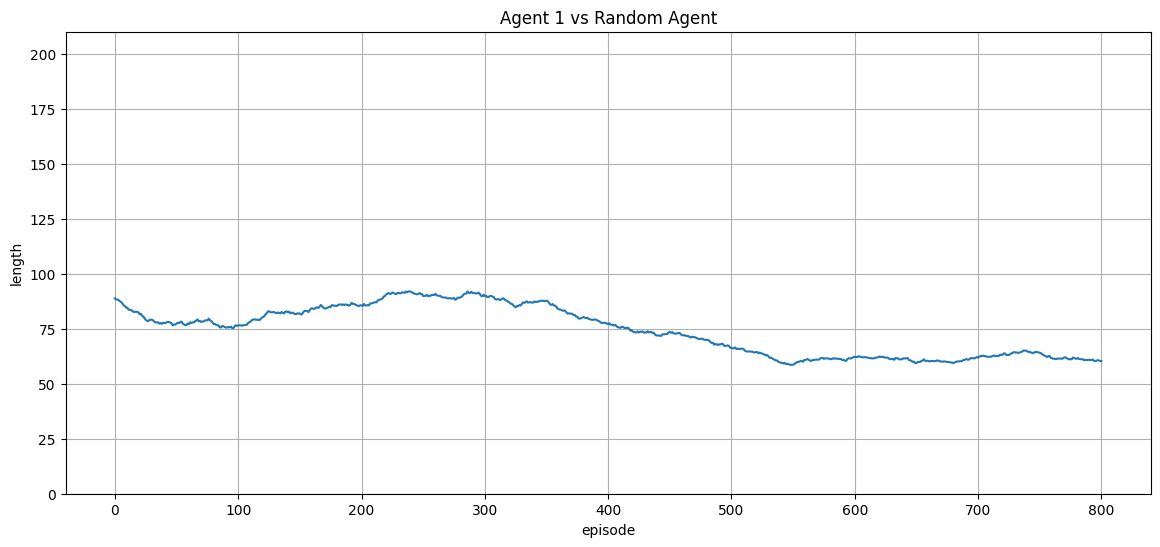

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(episode_lengths_2), 200)
)

ax.set(xlabel="episode", ylabel="length", ylim = (0, 210))
ax.grid()
ax.set_title("Agent 1 vs Random Agent")


plt.show()

Ok, this seem to indicate the agent learns some stuff. Keep in mind that it was not trained to catch a random agent, and that this is a different problem then catching a "smart" one, but it indicates that his police is reasonable. In fact we can see the agent already start improving in this problem after around 400 episodes.